# Employee Leave Predictor with Shap Explainer

In [5]:
#load Packages
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import xgboost as xgb
import shap
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import graphviz
import shap
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta, date
import calendar
import time
import os
import sys
import re
import warnings
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import model_selection
import graphviz
import shap 

#suppress warnings
warnings.filterwarnings('ignore')

#date function to generate dates for the insights data
def period(time_stamp, df):
    test_train_lbl =[]
    val = pd.to_datetime(df[time_stamp]).dt.strftime("%Y-%m-%d").values
    for i in val:
        if pd.to_datetime('2019-12-01')<= pd.to_datetime(i) <= pd.to_datetime('2020-05-31'):
            ttl = 'train'
            test_train_lbl.append(ttl)
        elif pd.to_datetime('2020-06-01')<= pd.to_datetime(i) <= pd.to_datetime('2020-12-31'):
            ttl = 'test'
            test_train_lbl.append(ttl)
        else:
            ttl = 'out of bound'
            test_train_lbl.append(ttl)
    df['test_train']= test_train_lbl
    return df
#test multiple models on data
def run_model(X_train,X_test,y_train,y_test):
    #models dictionary
    model_dict = [
             {'name':'Logistic Regression','model':LogisticRegression},
             {'name':'K Neighbors Classifier','model':KNeighborsClassifier},
             {'name':'Support Vector Classifier','model':SVC},
             {'name':'Naive Bayes Classifier','model':GaussianNB},
             {'name':'Random Forest Classifier','model':RandomForestClassifier},
             {'name':'XGBoost Classifier','model':XGBClassifier}
            ]
    #loop testing the data
    for classifier in model_dict:
        model = classifier['model']()
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        print(f"{classifier['name']} score is ",model.score(X_test, y_test))
        print(f"{classifier['name']} Report\n", classification_report(y_pred,y_test))
        print(f"{classifier['name']} Confusion Matrix\n", confusion_matrix(y_pred,y_test))
        
        
#function to reduce memory of data frames     
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


__Assume time is the greatest factor(effective month, days absent, pay days, date of employment,Hourly_rate,payday_flag, public_holiday_flag,weekend_flag, eight_week_flag ) changing in this data set while things like ('Gender', 'Date_of_employment', 'Province', 'Division_1', 'Division_2', 'Division_3',
       'Division_4', 'Division_5', 'Employee_type_1', 'Employee_type_2')__

## Load data remove columns with na values and filter for emp available in august 2019

In [2]:
#load data
df1 = pd.read_excel("assign1.xlsx")
df2 = pd.read_excel("assign2.xlsx")

#manipulate data
df1.columns = df1.columns.str.replace(" ", "_")
df1["Effective_month"] = pd.to_datetime(df1["Effective_month"]).dt.strftime("%Y-%m-%d")
df2["First_date"] = pd.to_datetime(df2["First_date"]).dt.strftime("%Y-%m-%d")
df2["Last_Date"] = pd.to_datetime(df2["Last_Date"]).dt.strftime("%Y-%m-%d")

df1["Employee_number"] = df1["Employee_number"].astype(str)
df2["Employee_number"] = df2["Employee_number"].astype(str)

#assuming all employees within the august date period will be in the september period as well
List_ids=df1.loc[df1["Effective_month"]=='2019-08-01'].Employee_number.unique().tolist()
df1=df1.dropna(axis = 1)
df2=df2.dropna(axis = 1)
df1 = df1[df1['Employee_number'].isin(List_ids)]
df2 = df2[df2['Employee_number'].isin(List_ids)]

## Build a csv with encoded binary absent sick leave days and potential flags

In [6]:
for emp_id in df2['Employee_number'].unique():
        df_test = df2.loc[df2["Employee_number"]==emp_id].loc[df2["Leave_type"]=="Sick Leave"]
        
        df_test = df_test[['Employee_number', 
                           'First_date', 
                           'Last_Date',
                           'payday_flag',
                           'public_holiday_flag',
                           'weekend_flag',
                           'eight_week_flag']].reset_index()
        
        df_test["First_date"] = pd.to_datetime(df_test["First_date"]).dt.strftime("%Y-%m-%d")
        df_test["Last_Date"] = pd.to_datetime(df_test["Last_Date"]).dt.strftime("%Y-%m-%d")
        df_test["index"] = df_test["index"].astype(str)
        
        df_test.columns = ['id', 
                           'Employee_number', 
                           'First_date', 
                           'Last_Date',
                           'payday_flag',
                           'public_holiday_flag',
                           'weekend_flag',
                           'eight_week_flag']
        

        def gen_2(dfx):  
            
            df = dfx[0]
            x = dfx[1]
            df = df.loc[df['id']==x]
            
            
            
            start = datetime.strptime(df["First_date"].max(), "%Y-%m-%d")
            end = datetime.strptime(df["Last_Date"].max(), "%Y-%m-%d")
            date_generated = [start + timedelta(days=y) for y in range(0, ((end+timedelta(days=1))-start).days)]
            
            leave_df = pd.DataFrame(date_generated, columns = ['date'])
            leave_df["id"]=x
            leave_df["Employee_number"] = df["Employee_number"].max()
            leave_df["payday_flag"] = df_test["payday_flag"].max()
            leave_df["public_holiday_flag"] = df_test["public_holiday_flag"].max()
            leave_df["weekend_flag"] = df_test["weekend_flag"].max()
            leave_df["eight_week_flag"] = df_test["eight_week_flag"].max()
            
            
            if not os.path.isfile('leave.csv'):
               leave_df.to_csv('leave.csv', header='column_names')
            else: # else it exists so append without writing the header
               leave_df.to_csv('leave.csv', mode='a', header=False)
        
        
        list_ids = df_test.id.unique().tolist()
        
        list_df_ids = []
        
        for i in range(len(list_ids)):
            list_df_ids.append([df_test,list_ids[i]])
        
        result = list((map (gen_2,list_df_ids)))

In [9]:
#this fuctions generates dates for all the Employees who were on retention in August 
def gen(dfx):  
    
        
    df = dfx[0]
    x = dfx[1]
    df = df[df['Employee_number']==x]
    
    start = datetime.strptime(df.Effective_month.min(), "%Y-%m-%d")
    end = datetime.strptime("2019-09-01", "%Y-%m-%d")
    date_generated = [start + timedelta(days=x) for x in range(0, (end-start).days)]
    
    new_date_df = pd.DataFrame(date_generated, columns = ['date'])
    new_date_df["Employee_number"] = x
    
    
    if not os.path.isfile('new_date_df.csv'):
       new_date_df.to_csv('new_date_df.csv', header='column_names')
    else: # else it exists so append without writing the header
       new_date_df.to_csv('new_date_df.csv', mode='a', header=False)


list_ids=df1.loc[df1["Effective_month"]=='2019-08-01'].Employee_number.unique().tolist()

list_df_ids = []

for i in range(len(list_ids)):
    list_df_ids.append([df1,list_ids[i]])

result = list((map (gen,list_df_ids)))

In [10]:
comb_1 = pd.read_csv('new_date_df.csv')
comb_2 = pd.read_csv("leave.csv")

total_days = comb_1.loc[:, ~comb_1.columns.str.contains('^Unnamed')]
leave_days = comb_2.loc[:, ~comb_2.columns.str.contains('^Unnamed')]
leave_days = leave_days[['date',
                         'Employee_number', 
                         'payday_flag',
                         'public_holiday_flag',
                         'weekend_flag',
                         'eight_week_flag']]

leave_days["absent"] = 1

#data types
leave_days["date"]=pd.to_datetime(leave_days["date"]).dt.strftime("%Y-%m-%d")
total_days["date"]=pd.to_datetime(total_days["date"]).dt.strftime("%Y-%m-%d")

leave_days["Employee_number"]=leave_days["Employee_number"].astype(str)
total_days["Employee_number"]=total_days["Employee_number"].astype(str)


In [11]:
combined = pysqldf("""Select
                           d1.Employee_number,
                           d1.date,
                           d2.payday_flag,
                           d2.public_holiday_flag,
                           d2.weekend_flag,
                           d2.eight_week_flag,
                           d2.absent
                   from 
                       total_days as d1
                   Left Join leave_days as d2
                       on d1.Employee_number=d2.Employee_number
                       and d1.date = d2.date
                       
                   """).fillna(0)
#at this point a logistic regression model can even be ran for each of the keys to generate 

## Combine the leave with the employee work details df1

In [12]:
comb_sick = combined.copy()
comb_sick["month"]=pd.to_datetime(comb_sick["date"]).dt.strftime("%Y-%m")
comb_sick=comb_sick.groupby(["month", "Employee_number"]).agg({"payday_flag":"max","weekend_flag":"max", "eight_week_flag":"max","public_holiday_flag":"max","absent":"sum" }).reset_index()
comb_sick["Effective_month"] = pd.to_datetime(comb_sick["month"]+'-'+"01")

#### use effective month with the Date_of_employment and Date_of_birth to calculate the years of service and the age

In [13]:
#combine df1 with comb_sick
df1.Effective_month= pd.to_datetime(df1.Effective_month)
combine_df = comb_sick.merge(df1,how='inner',on=('Employee_number','Effective_month'))
combine_df = combine_df.drop(['month' ], axis = 1)

#calculate age in days and days of service for each employee for the given effective month

combine_df["age_at_Effective_month"]=(combine_df.Effective_month-combine_df.Date_of_birth).dt.days
combine_df["service_at_Effective_month"]=(combine_df.Effective_month-combine_df.Date_of_employment).dt.days

category_col = ['Employee_number',
                'Gender', 
                'Division_1',
                'Division_2', 
                'Division_4', 
                'Division_5', 
                'Employee_Type_2', 
                'Pay_type']


combine_df[category_col] = combine_df[category_col].astype('category')
combine_df[category_col] = combine_df[category_col].apply(lambda x: x.cat.codes)


combine_df['year']=pd.to_datetime(combine_df["Effective_month"]).dt.year
combine_df['month']=pd.to_datetime(combine_df["Effective_month"]).dt.month
combine_df = combine_df.drop(['Effective_month','Date_of_birth','Date_of_employment'], axis = 1)
#,'Division_1','Pay_type','Division_4','year','Gender','Work_hours_in_month'
combine_df = combine_df.astype(float)

In [14]:
y = combine_df.absent
x = combine_df.loc[:,combine_df.columns != "absent"]

In [17]:
#test multiple models
X_train, X_test, y_train,y_test=train_test_split(x,y, test_size= 0.2, random_state =123)
run_model(X_train,X_test,y_train,y_test)

Logistic Regression score is  0.9248313523931898
Logistic Regression Report
               precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     12452
         4.0       0.00      0.00      0.00         0
         8.0       0.00      0.00      0.00         0
        12.0       0.00      0.00      0.00         0
        16.0       0.00      0.00      0.00         0
        20.0       0.00      0.00      0.00         0
        24.0       0.00      0.00      0.00         0
        28.0       0.00      0.00      0.00         0
        32.0       0.00      0.00      0.00         0
        36.0       0.00      0.00      0.00         0
        40.0       0.00      0.00      0.00         0
        44.0       0.00      0.00      0.00         0
        48.0       0.00      0.00      0.00         0
        52.0       0.00      0.00      0.00         0
        56.0       0.00      0.00      0.00         0
        60.0       0.00      0.00      0.00         0
    

Support Vector Classifier score is  0.9248313523931898
Support Vector Classifier Report
               precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     12452
         4.0       0.00      0.00      0.00         0
         8.0       0.00      0.00      0.00         0
        12.0       0.00      0.00      0.00         0
        16.0       0.00      0.00      0.00         0
        20.0       0.00      0.00      0.00         0
        24.0       0.00      0.00      0.00         0
        28.0       0.00      0.00      0.00         0
        32.0       0.00      0.00      0.00         0
        36.0       0.00      0.00      0.00         0
        40.0       0.00      0.00      0.00         0
        44.0       0.00      0.00      0.00         0
        48.0       0.00      0.00      0.00         0
        52.0       0.00      0.00      0.00         0
        56.0       0.00      0.00      0.00         0
        60.0       0.00      0.00      0.00   

Random Forest Classifier score is  0.944025056215869
Random Forest Classifier Report
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     11577
         4.0       0.36      0.34      0.35       307
         8.0       0.33      0.33      0.33       281
        12.0       0.20      0.21      0.20       189
        16.0       0.08      0.12      0.10        33
        20.0       0.07      0.10      0.08        30
        24.0       0.00      0.00      0.00         6
        28.0       0.00      0.00      0.00         4
        32.0       0.08      0.17      0.11         6
        36.0       0.00      0.00      0.00         2
        40.0       0.00      0.00      0.00         2
        44.0       0.00      0.00      0.00         2
        48.0       0.00      0.00      0.00         2
        52.0       0.00      0.00      0.00         1
        56.0       0.00      0.00      0.00         3
        60.0       0.00      0.00      0.00      

## Based on the expt above the data predicts better when we use a tree based model

In [608]:
df_dmatrix=xgb.DMatrix(data=x, label=y)
x_train, x_test, y_train,y_test=train_test_split(x,y, test_size= 0.2, random_state =123)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',colsample_bytree =0.3, learning_rate =0.01, max_depth = 5, alpha=10,
                         n_estimators = 10)

In [611]:
x_train, x_test, y_train,y_test=train_test_split(x,y, test_size= 0.2, random_state =123)
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }
num_boost_round = 1000
params['eval_metric']="rmse"

print("Train a XGBoost model")
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

watchlist = [(dtrain, 'train'), (dtest, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=16, verbose_eval=True)

d_test = xgb.DMatrix(x_test)
test_probs = gbm.predict(d_test)
result = pd.DataFrame({'act_leave': y_test, 'pred_leave': test_probs})

Train a XGBoost model
[0]	train-rmse:1.02845	eval-rmse:1.01317
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 16 rounds.
[1]	train-rmse:0.89509	eval-rmse:0.945924
[2]	train-rmse:0.812103	eval-rmse:0.915926
[3]	train-rmse:0.749137	eval-rmse:0.899287
[4]	train-rmse:0.696599	eval-rmse:0.879964
[5]	train-rmse:0.642197	eval-rmse:0.877793
[6]	train-rmse:0.615024	eval-rmse:0.879859
[7]	train-rmse:0.594466	eval-rmse:0.882073
[8]	train-rmse:0.568064	eval-rmse:0.882341
[9]	train-rmse:0.540609	eval-rmse:0.878503
[10]	train-rmse:0.51983	eval-rmse:0.877595
[11]	train-rmse:0.494809	eval-rmse:0.878451
[12]	train-rmse:0.472094	eval-rmse:0.879499
[13]	train-rmse:0.461177	eval-rmse:0.87685
[14]	train-rmse:0.446156	eval-rmse:0.874593
[15]	train-rmse:0.442119	eval-rmse:0.875043
[16]	train-rmse:0.422664	eval-rmse:0.873314
[17]	train-rmse:0.418589	eval-rmse:0.873474
[18]	train-rmse:0.406191	eval-rmse:0.874927
[19]	train-rms

In [612]:
result.corr()

,act_leave,pred_leave
act_leave,1.00000,0.62772
pred_leave,0.62772,1.00000


In [613]:
params =  {"objective":"reg:squarederror",
           "booster" : "gbtree",
           "eta": 0.3,
           'colsample_by_tree':0.7,
           'learning_rate':0.01,
           'max_depth':7,
           'alpha':10,
           "silent": 1,
           "seed": 1301}
cv_results =xgb.cv(dtrain= df_dmatrix, params = params, nfold =10, num_boost_round =10, early_stopping_rounds=7, metrics='rmse', as_pandas =True, seed =123)

xg_reg = xgb.train(params = params, dtrain = df_dmatrix,num_boost_round =10)

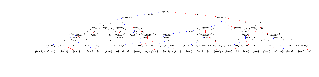

In [614]:
xgb.plot_tree(xg_reg,num_trees = 0)
plt.rcParams['figure.figsize']=[50,50]
plt.show()

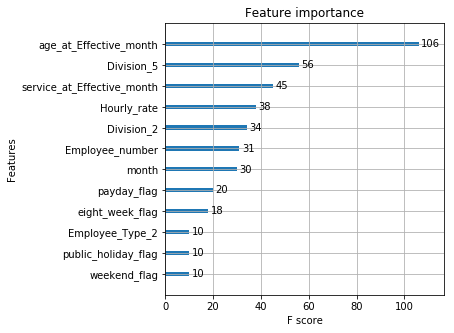

In [616]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize']=[5,5]
plt.show()

In [603]:
shap.initjs()
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(x)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x.iloc[0,:])

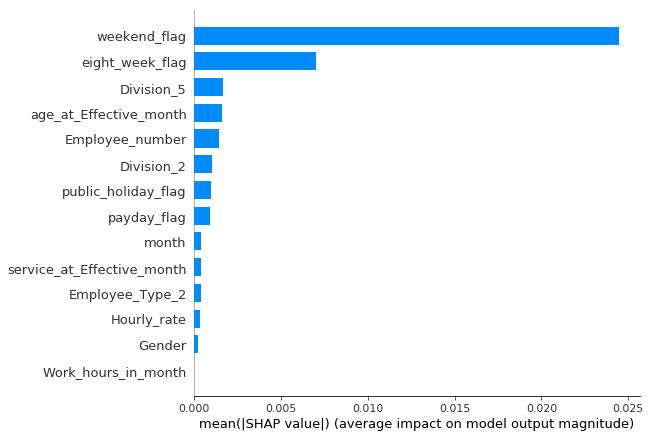

In [604]:
shap.summary_plot(shap_values, x, plot_type="bar")

# Method 2

In [639]:
comb = combined.copy()

In [640]:
comb['year']=pd.to_datetime(comb["date"]).dt.year
comb['month']=pd.to_datetime(comb["date"]).dt.month
comb['day']=pd.to_datetime(comb["date"]).dt.day
comb['dow']=pd.to_datetime(comb["date"]).dt.dayofweek

In [641]:
comb["Employee_number"]=comb["Employee_number"].astype('category')

In [642]:
comb["Employee_number"]=comb["Employee_number"].cat.codes

In [644]:
comb.dtypes

Employee_number          int16
date                    object
payday_flag            float64
public_holiday_flag    float64
weekend_flag           float64
eight_week_flag        float64
absent                 float64
year                     int64
month                    int64
day                      int64
dow                      int64
dtype: object

In [650]:
comb = comb.drop('date', axis =1)

In [651]:
comb=comb.astype(float)

In [653]:
comb.head(5)

,Employee_number,payday_flag,public_holiday_flag,weekend_flag,eight_week_flag,absent,year,month,day,dow
0,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,3.0,1.0,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,3.0,2.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,3.0,3.0,4.0
3,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,3.0,4.0,5.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,3.0,5.0,6.0


In [655]:
y = comb.absent
x = comb.loc[:,comb.columns != "absent"]
df_dmatrix=xgb.DMatrix(data=x, label=y)

/Users/kudzayimabuto/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/kudzayimabuto/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



In [656]:
x_train, x_test, y_train,y_test=train_test_split(x,y, test_size= 0.2, random_state =123)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',colsample_bytree =0.3, learning_rate =0.01, max_depth = 5, alpha=10,
                         n_estimators = 10)

In [ ]:
# finding the appropriate numbe of itertions with the best evaluation metric in this cas rmse

In [658]:
x_train, x_test, y_train,y_test=train_test_split(x,y, test_size= 0.2, random_state =123)
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }
num_boost_round = 10000
params['eval_metric']="rmse"

print("Train a XGBoost model")
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

watchlist = [(dtrain, 'train'), (dtest, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, verbose_eval=True)

d_test = xgb.DMatrix(x_test)
test_probs = gbm.predict(d_test)
result = pd.DataFrame({'act_leave': y_test, 'pred_leave': test_probs})

Train a XGBoost model
[0]	train-rmse:0.352308	eval-rmse:0.350058
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:0.246257	eval-rmse:0.246318
[2]	train-rmse:0.173904	eval-rmse:0.172544
[3]	train-rmse:0.121578	eval-rmse:0.122293
[4]	train-rmse:0.087143	eval-rmse:0.08726
[5]	train-rmse:0.063332	eval-rmse:0.0638
[6]	train-rmse:0.047402	eval-rmse:0.047616
[7]	train-rmse:0.037168	eval-rmse:0.037266
[8]	train-rmse:0.030926	eval-rmse:0.031078
[9]	train-rmse:0.027041	eval-rmse:0.027147
[10]	train-rmse:0.025146	eval-rmse:0.025122
[11]	train-rmse:0.023758	eval-rmse:0.02383
[12]	train-rmse:0.022998	eval-rmse:0.023306
[13]	train-rmse:0.022569	eval-rmse:0.023001
[14]	train-rmse:0.02208	eval-rmse:0.022415
[15]	train-rmse:0.021843	eval-rmse:0.022226
[16]	train-rmse:0.021832	eval-rmse:0.022194
[17]	train-rmse:0.021824	eval-rmse:0.022174
[18]	train-rmse:0.021708	eval-rmse:0.022124
[19]	train-rm

[182]	train-rmse:0.01112	eval-rmse:0.018448
[183]	train-rmse:0.011078	eval-rmse:0.018434
[184]	train-rmse:0.011061	eval-rmse:0.018436
[185]	train-rmse:0.011038	eval-rmse:0.018445
[186]	train-rmse:0.011038	eval-rmse:0.018445
[187]	train-rmse:0.011019	eval-rmse:0.018435
[188]	train-rmse:0.011019	eval-rmse:0.018435
[189]	train-rmse:0.011019	eval-rmse:0.018435
[190]	train-rmse:0.011012	eval-rmse:0.018444
[191]	train-rmse:0.010906	eval-rmse:0.018394
[192]	train-rmse:0.010884	eval-rmse:0.018406
[193]	train-rmse:0.010884	eval-rmse:0.018406
[194]	train-rmse:0.010884	eval-rmse:0.018406
[195]	train-rmse:0.010884	eval-rmse:0.018406
[196]	train-rmse:0.010872	eval-rmse:0.018415
[197]	train-rmse:0.010868	eval-rmse:0.018421
[198]	train-rmse:0.010777	eval-rmse:0.018363
[199]	train-rmse:0.010686	eval-rmse:0.018324
[200]	train-rmse:0.010599	eval-rmse:0.018334
[201]	train-rmse:0.010503	eval-rmse:0.018336
[202]	train-rmse:0.010321	eval-rmse:0.018178
[203]	train-rmse:0.010224	eval-rmse:0.018163
[204]	train

[365]	train-rmse:0.007488	eval-rmse:0.017989
[366]	train-rmse:0.007479	eval-rmse:0.017989
[367]	train-rmse:0.007476	eval-rmse:0.017993
[368]	train-rmse:0.007449	eval-rmse:0.017999
[369]	train-rmse:0.007439	eval-rmse:0.017997
[370]	train-rmse:0.007439	eval-rmse:0.017997
[371]	train-rmse:0.007395	eval-rmse:0.017968
[372]	train-rmse:0.007287	eval-rmse:0.017908
[373]	train-rmse:0.007269	eval-rmse:0.017917
[374]	train-rmse:0.00725	eval-rmse:0.017932
[375]	train-rmse:0.007249	eval-rmse:0.017932
[376]	train-rmse:0.007249	eval-rmse:0.017932
[377]	train-rmse:0.007207	eval-rmse:0.01795
[378]	train-rmse:0.007188	eval-rmse:0.01796
[379]	train-rmse:0.007188	eval-rmse:0.01796
[380]	train-rmse:0.007101	eval-rmse:0.01791
[381]	train-rmse:0.007079	eval-rmse:0.017913
[382]	train-rmse:0.007077	eval-rmse:0.017911
[383]	train-rmse:0.007059	eval-rmse:0.01792
[384]	train-rmse:0.007051	eval-rmse:0.017922
[385]	train-rmse:0.006927	eval-rmse:0.01784
[386]	train-rmse:0.006911	eval-rmse:0.017844
[387]	train-rmse:

[549]	train-rmse:0.005387	eval-rmse:0.017824
[550]	train-rmse:0.005387	eval-rmse:0.017824
[551]	train-rmse:0.005387	eval-rmse:0.017824
[552]	train-rmse:0.005387	eval-rmse:0.017824
[553]	train-rmse:0.00538	eval-rmse:0.017827
[554]	train-rmse:0.00538	eval-rmse:0.017827
[555]	train-rmse:0.005326	eval-rmse:0.01781
[556]	train-rmse:0.005326	eval-rmse:0.01781
[557]	train-rmse:0.005303	eval-rmse:0.017801
[558]	train-rmse:0.005299	eval-rmse:0.017797
[559]	train-rmse:0.005263	eval-rmse:0.017765
[560]	train-rmse:0.005263	eval-rmse:0.017765
[561]	train-rmse:0.005253	eval-rmse:0.01777
[562]	train-rmse:0.005253	eval-rmse:0.017769
[563]	train-rmse:0.005244	eval-rmse:0.017766
[564]	train-rmse:0.005244	eval-rmse:0.017766
[565]	train-rmse:0.005244	eval-rmse:0.017766
[566]	train-rmse:0.005241	eval-rmse:0.017769
[567]	train-rmse:0.005236	eval-rmse:0.017772
[568]	train-rmse:0.005234	eval-rmse:0.017775
[569]	train-rmse:0.005232	eval-rmse:0.017776
[570]	train-rmse:0.005228	eval-rmse:0.017778
[571]	train-rms

In [672]:
result[result["act_leave"]==1].round()

,act_leave,pred_leave
1330026,1.0,1.0
1244030,1.0,1.0
1505269,1.0,1.0
82720,1.0,1.0
1600841,1.0,1.0
687310,1.0,1.0
297692,1.0,1.0
942286,1.0,1.0
403951,1.0,1.0
932753,1.0,1.0


In [659]:
result.corr()

,act_leave,pred_leave
act_leave,1.000000,0.976283
pred_leave,0.976283,1.000000


In [ ]:
# Cross validation

In [660]:
params =  {"objective":"reg:squarederror",
           "booster" : "gbtree",
           "eta": 0.3,
           'colsample_by_tree':0.7,
           'learning_rate':0.01,
           'max_depth':7,
           'alpha':10,
           "silent": 1,
           "seed": 1301}
cv_results =xgb.cv(dtrain= df_dmatrix, params = params, nfold =10, num_boost_round =500, early_stopping_rounds=471, metrics='rmse', as_pandas =True, seed =123)

xg_reg = xgb.train(params = params, dtrain = df_dmatrix,num_boost_round =10)

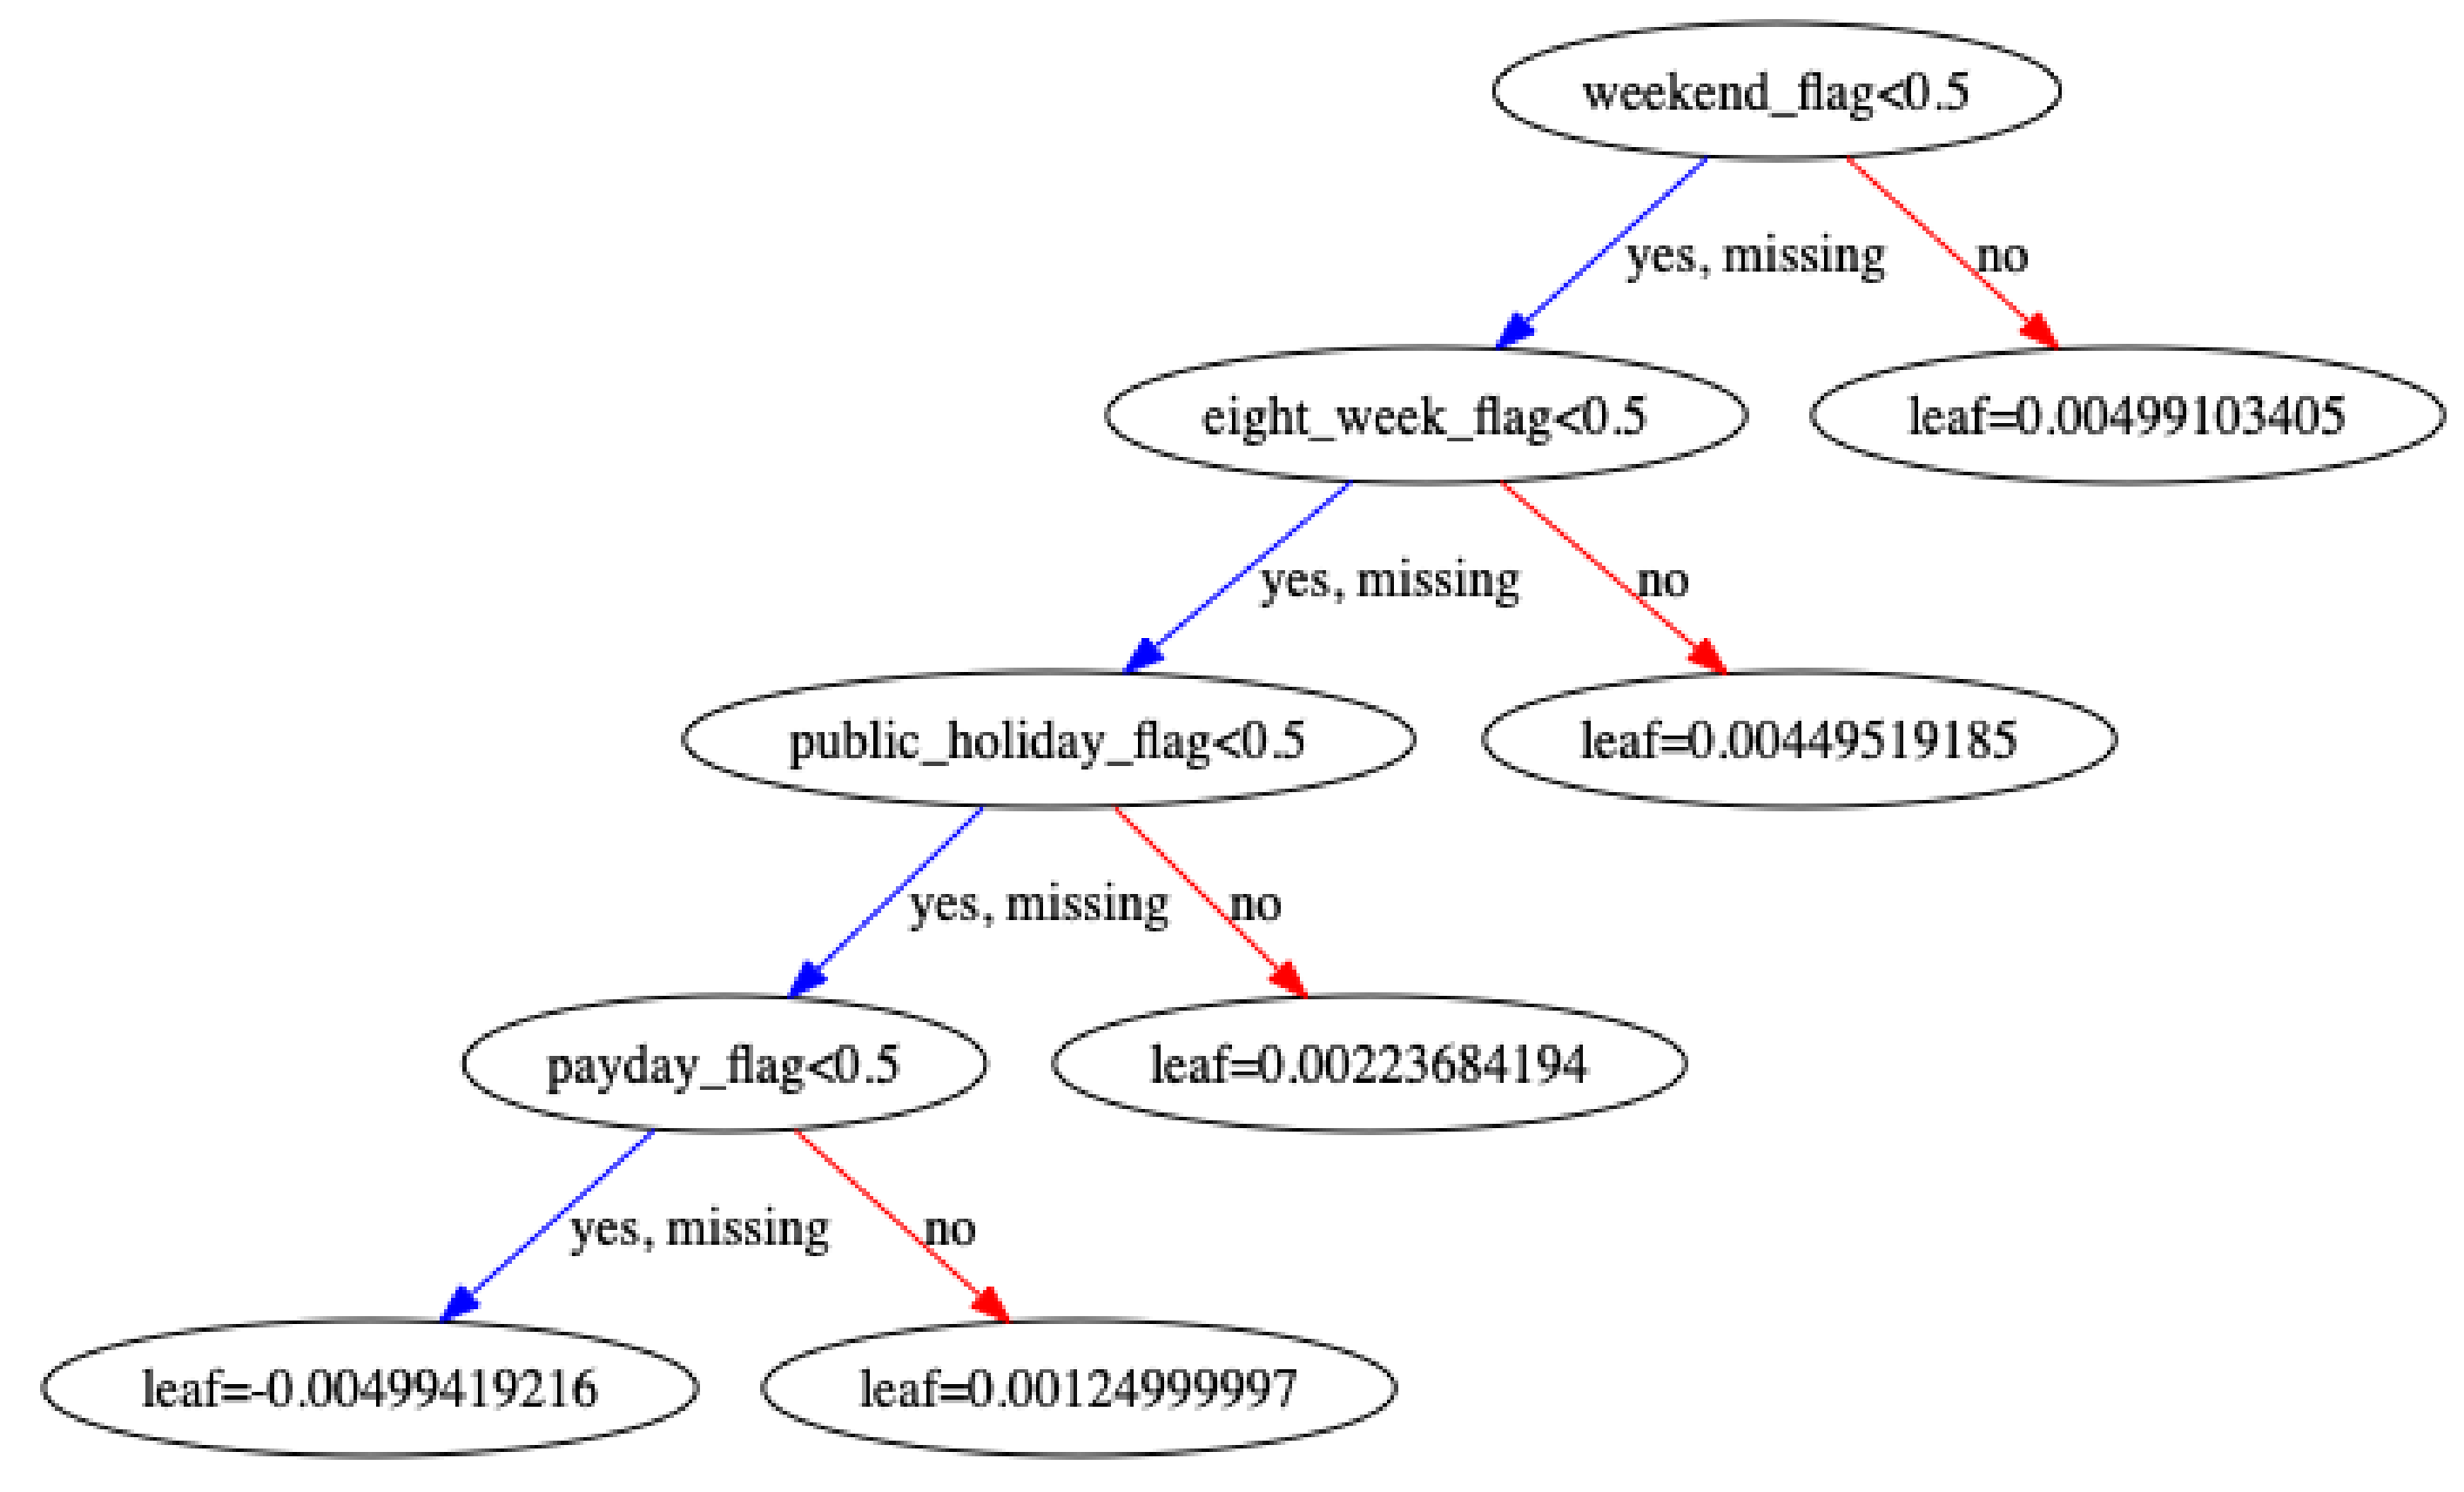

In [662]:
xgb.plot_tree(xg_reg,num_trees = 0)
plt.rcParams['figure.figsize']=[50,50]
plt.show()

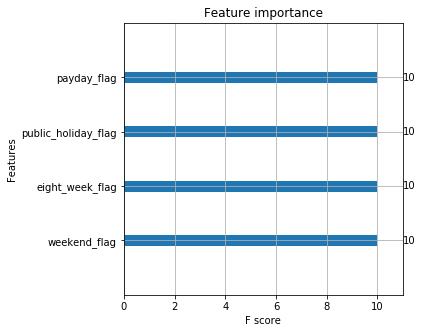

In [664]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize']=[5,5]
plt.show()

In [665]:
shap.initjs()
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(x)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x.iloc[0,:])

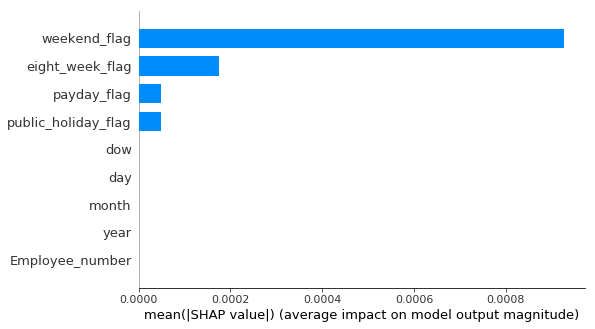

In [666]:
shap.summary_plot(shap_values, x, plot_type="bar")